# Personal loan Data 를 활용한 Review 

지금까지 배워원 머신러닝 방법론 중에서 분류문제에 사용가능한 방법론들을 각자 최적화후 그 성능을 비교해보도록 하겠습니다. 

1. Logistic Regression
2. Logistic Regression(forward)
3. Logistic Regression(backward)
4. Logistic Regression(stepwise)
5. Decision Tree(Default)
6. Decision Tree(parameter_optimal)



#### **필요 패키지 불러오기**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,confusion_matrix,f1_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools
import time



#### **변수선택함수 불러오기**

In [2]:
def processSubset(X,y, feature_set):
            model = sm.Logit(y,X[list(feature_set)])
            regr = model.fit()
            AIC = regr.aic
            return {"model":regr, "AIC":AIC}
        
'''
전진선택법
'''
def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [ k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return(Fmodels['model'][len(Fmodels['model'])])


'''
후진소거법
'''
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model


def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Bmodels['model'].dropna().iloc[0])


'''
단계적 선택법
'''
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [3]:
### Data 불러오기
ploan = pd.read_csv("./data/personal_loan.csv")
# 의미없는 변수 제거
ploan_processed = ploan.dropna().drop(['ID','ZIP Code'], axis=1, inplace=False)
# 상수항 추가
ploan_processed = sm.add_constant(ploan_processed, has_constant='add')

feature_columns = list(ploan_processed.columns.difference(["Personal Loan"]))
X = ploan_processed[feature_columns]
y = ploan_processed['Personal Loan'] 


### Metric Calculation
def perf_eval(cm):
    # True positive rate: TPR
    TPR = cm[1, 1] / sum(cm[1]) # recall
    # True negative rate: TNR
    TNR = cm[0, 0] / sum(cm[0])
    # Simple Accuracy
    ACC = (cm[0, 0] + cm[1, 1]) / sum(cm.reshape(-1,))
    # Balanced Correction Rate
    BCR = np.sqrt(TPR * TNR)
    # F1-measure
    Precision = cm[1,1] /sum(cm[:,1])
    F1 = 2*TPR*Precision/(TPR+Precision)
    return ([TPR, TNR, ACC, BCR, F1])

def cut_off(y,threshold):
    Y = y.copy() # copy함수를 사용하여 이전의 y값이 변화지 않게 함
    Y[ y>threshold]=1
    Y[ y<=threshold]=0
    return(Y.astype(int))




In [4]:
# 학습데이터와 검증데이터 7:3으로 나누기

train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y,train_size=0.7,test_size=0.3,random_state=5959)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)


(1750, 12) (750, 12) (1750,) (750,)


### **1.Logistic Regression(full)**

In [5]:

lr_model = sm.Logit(train_y, train_x)
lrbase_results = lr_model.fit(method='newton')


Optimization terminated successfully.
         Current function value: 0.119081
         Iterations 9


### **2.Logistic Regression(forward)**

In [6]:
Forward_lr_model = forward_model(X=train_x, y= train_y)


Optimization terminated successfully.
         Current function value: 0.330076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.290616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.196473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.324535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329760
  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Optimization terminated successfully.
         Current function value: 0.120652
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121267
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120979
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120171
         Iterations 9
Processed  5 models on 7 predictors in 0.018948793411254883
Selected predictors: ['Income', 'Education', 'CD Account', 'Family', 'CreditCard', 'CCAvg', 'Securities Account', 'const']  AIC: 436.598786425105
Optimization terminated successfully.
         Current function value: 0.119451
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.119484
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120164


### **3.Logistic Regression(backward)**

In [7]:
Backward_lr_model = backward_model(X=train_x, y= train_y)

Optimization terminated successfully.
         Current function value: 0.127301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.119432
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.119081
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.200511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.133008
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.119100
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.146541
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136034
  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


### **4.Logistic Regression(stepwise)**

In [8]:
Stepwise_lr_model = Stepwise_model(X=train_x, y= train_y)

Optimization terminated successfully.
         Current function value: 0.330076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.290616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.196473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.324535
  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


Optimization terminated successfully.
         Current function value: 0.196093
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.195497
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.196463
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.154431
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196245
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173234
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.196084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.195642
  

#### 로지스틱 회귀 분석 모형들 예측하기


In [9]:
pred_y_lr = lrbase_results
pred_y_lrforward = Forward_lr_model.predict(test_x[Forward_lr_model.model.exog_names])
pred_y_lrbackward = Backward_lr_model.predict(test_x[Backward_lr_model.model.exog_names])
pred_y_lrstepwise = Stepwise_lr_model.predict(test_x[Stepwise_lr_model.model.exog_names])


In [10]:
# Cut-off 동일하게 0.5
pred_Y_full= cut_off(pred_y_lrforward,0.5)
pred_Y_forward = cut_off(pred_y_lrbackward,0.5)
pred_Y_backward = cut_off(pred_y_lrbackward,0.5)
pred_Y_stepwise = cut_off(pred_y_lrstepwise,0.5)

## **혼동행렬으로 표현**

In [11]:
cfmat_full = confusion_matrix(test_y, pred_Y_full)
cfmat_forward = confusion_matrix(test_y, pred_Y_forward)
cfmat_backward = confusion_matrix(test_y, pred_Y_backward)
cfmat_stepwise = confusion_matrix(test_y, pred_Y_stepwise)

## **성능비교**

In [12]:
perf_mat = pd.DataFrame(columns=["TPR", "TNR", "ACC", "BCR","F1"],
                        index =['LR_FULL', 'LR_FORWARD','LR_BACKWARD', 'LR_STEPWISE'])


perf_mat.loc['LR_FULL']=perf_eval(cfmat_full)
perf_mat.loc['LR_FORWARD']=perf_eval(cfmat_forward)
perf_mat.loc['LR_BACKWARD']=perf_eval(cfmat_backward)
perf_mat.loc['LR_STEPWISE']=perf_eval(cfmat_stepwise)

In [13]:
perf_mat

,TPR,TNR,ACC,BCR,F1
LR_FULL,0.558442,0.980684,0.937333,0.740037,0.646617
LR_FORWARD,0.558442,0.980684,0.937333,0.740037,0.646617
LR_BACKWARD,0.558442,0.980684,0.937333,0.740037,0.646617
LR_STEPWISE,0.558442,0.980684,0.937333,0.740037,0.646617


## **Defualt DecisionTree 적합하기**

In [14]:
defualt_dt = DecisionTreeClassifier(criterion='gini',#'entropy'
                                random_state=3355)

In [15]:
defualt_dt.fit(train_x, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3355,
            splitter='best')

In [16]:
df_default_pred = defualt_dt.predict(test_x)

In [17]:
cfmat_dt_defualt = confusion_matrix(test_y,df_default_pred)

In [18]:
print(cfmat_dt_defualt)

[[659  14]
 [ 12  65]]


## **최적화된 데이터의 학습 DecisionTree 적합하기**

In [19]:
# 가장 좋은 'max_depth' hyperparameter 값을 찾아보자
max_depths = list(range(1, 15, 1))
test_accs = []
test_f1 = []
dt_models = []
for max_depth in max_depths:
    clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=3355)
    clf_dt.fit(train_x, train_y)
    dt_models.append(clf_dt)
    y_valid_pred = clf_dt.predict(test_x)
    test_accs.append(accuracy_score(test_y, y_valid_pred))
    test_f1.append(f1_score(test_y, y_valid_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


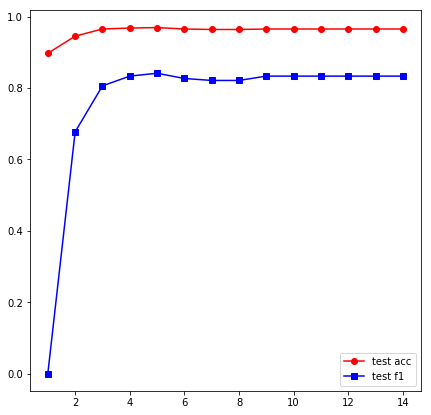

In [20]:
# 가장 좋은 'max_depth' hyperparameter 값 찾기위한 정확도, f1 그래프 그리기
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(max_depths, test_accs, color='red', marker='o', label='test acc')
ax.plot(max_depths, test_f1, color='blue', marker='s', label='test f1')
ax.legend(loc='best')
plt.show(fig)

In [21]:
best_model_idx, best_model_f1 = max(enumerate(test_f1), key=lambda p: p[1])
df_opt_pred = dt_models[best_model_idx].predict(test_x)

In [22]:
cfmat_dt_opt = confusion_matrix(test_y,df_opt_pred)

In [23]:
print(cfmat_dt_opt)

[[666   7]
 [ 16  61]]


In [24]:
perf_mat_summary = pd.DataFrame(columns=["TPR", "TNR", "ACC", "BCR","F1"],
                        index =['LR_FULL', 'LR_FORWARD','LR_BACKWARD', 'LR_STEPWISE',
                               'DT_default','DT_tuned'])


perf_mat_summary.loc['LR_FULL']=perf_eval(cfmat_full)
perf_mat_summary.loc['LR_FORWARD']=perf_eval(cfmat_forward)
perf_mat_summary.loc['LR_BACKWARD']=perf_eval(cfmat_backward)
perf_mat_summary.loc['LR_STEPWISE']=perf_eval(cfmat_stepwise)
perf_mat_summary.loc['DT_default']=perf_eval(cfmat_dt_defualt)
perf_mat_summary.loc['DT_tuned']=perf_eval(cfmat_dt_opt)



In [25]:
print(perf_mat_summary)

                  TPR       TNR       ACC       BCR        F1
LR_FULL      0.558442  0.980684  0.937333  0.740037  0.646617
LR_FORWARD   0.558442  0.980684  0.937333  0.740037  0.646617
LR_BACKWARD  0.558442  0.980684  0.937333  0.740037  0.646617
LR_STEPWISE  0.558442  0.980684  0.937333  0.740037  0.646617
DT_default   0.844156  0.979198  0.965333  0.909173  0.833333
DT_tuned     0.792208  0.989599  0.969333   0.88542  0.841379
